In [1]:
# Author: Arjun Viswanathan
# Date Created: 5/26/22
# Creating a Siamese Neural Network (SNN) architecture using PyTorch. The jupyter notebook version.
# Network takes in 2 sets of inputs, and trains on them to give 2 sets of outputs.
# These outputs are then used to compute a distance, and this is passed into a Dense layer to give the output of the SNN

'''
Log:
5/24: Created file and started the SNN construction. Added in data loading and training to test out with MNIST
database but there were errors in setting up the training.
5/26: After consulting some sample code from a friend, fixed the training code and data loaders. Tested it and it
works, just not very well. Current train accuracy is 10.5% and test accuracy is 11.37%. Will need to adjust parameters.
5/31: Changed up the SNN model and made some big changes to how the MNIST data is made. Currently unable to set up the 
DataLoader, which I will do later. Once that is working, training can be done. 
6/1: Copied from jupyter notebook to google collab, and ran the code and got the data to be made. Now the model has a 
problem in the Convolutional filters. Need to fix
'''

'\nLog:\n5/24: Created file and started the SNN construction. Added in data loading and training to test out with MNIST\ndatabase but there were errors in setting up the training.\n5/26: After consulting some sample code from a friend, fixed the training code and data loaders. Tested it and it\nworks, just not very well. Current train accuracy is 10.5% and test accuracy is 11.37%. Will need to adjust parameters.\n5/31: Changed up the SNN model and made some big changes to how the MNIST data is made. Currently unable to set up the \nDataLoader, which I will do later. Once that is working, training can be done. \n6/1: Copied from jupyter notebook to google collab, and ran the code and got the data to be made. Now the model has a \nproblem in the Convolutional filters. Need to fix\n'

In [2]:
pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import torch
import random
import math
from sklearn.model_selection import train_test_split
from torch.nn import Module, Conv2d, MaxPool2d, Linear
import torch.nn.functional as F
from torchvision import datasets as dts
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
import numpy as np

In [5]:
class CreateSiameseDataset(Dataset):
    def __init__(self):
        self.transform = transforms.Compose([transforms.ToTensor()])
        # download the MNIST database into a training and validation set, converting to a Tensor as we download
        self.dataset = dts.MNIST(
            root= './data',
            train= True,
            download= True,
            transform= self.transform
        )
        
        # Get the images and the labels from imported dataset. May change depending on how the dataset is imported in
        self.images = self.dataset.data
        self.targets = self.dataset.targets
    
    def __getitem__(self, index):
        coinflip = random.randint(0, 1) # 0: same image, 1: different image
        set1choice = random.randint(0, len(self.targets))
        if coinflip:
            while(True): # keep looping until we find the image we want that either matches or differentiates the original image
                set2choice = random.randint(0, len(self.targets))
                if(self.targets[set1choice] != self.targets[set2choice] and set1choice != set2choice):
                    img1 = self.images[set1choice]
                    img2 = self.images[set2choice]
                    label = torch.tensor(1)
                    break # load them and break for next coin flip
        else:
            while(True):
                set2choice = random.randint(0, len(self.targets))
                if(self.targets[set1choice] == self.targets[set2choice] and set1choice != set2choice):
                    img1 = self.images[set1choice]
                    img2 = self.images[set2choice]
                    label = torch.tensor(0)
                    break
        return img1, img2, label
    
    def __len__(self):
        return len(self.images)

In [6]:
siamesedata = CreateSiameseDataset()
batchsize = 64
siamesedataloader = DataLoader(siamesedata, shuffle=True, num_workers=2, batch_size=batchsize)

Label:  tensor(1)


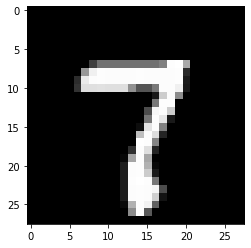

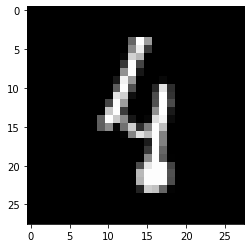

In [7]:
# plot the data and see what was created in the DataLoader
img1, img2, l = next(iter(siamesedataloader))
for i in range(1):
    plt.figure(i)
    plt.imshow(img1[i], cmap='gray')
    plt.figure(i+1)
    plt.imshow(img2[i], cmap='gray')
    print("Label: ", l[i])
    plt.show()

In [8]:
# Data logistics. We want it to be approx 50% of 1s and 0s to have good training
print("All labels: ", l)
print("Number of 1s: ", np.count_nonzero(l.numpy()==1))
print("Number of 0s: ", np.count_nonzero(l.numpy()==0))

All labels:  tensor([1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0])
Number of 1s:  32
Number of 0s:  32


In [9]:
# view the dimensions and num classes of the input images
for (img1, img2, l) in siamesedataloader:
    print("Set Image Dimensions: ", img1.shape)
    print("Set Single Image Dimension: ", img1[0].shape)
    print("Set Label Dimensions: ", l.shape)
    break

Set Image Dimensions:  torch.Size([64, 28, 28])
Set Single Image Dimension:  torch.Size([28, 28])
Set Label Dimensions:  torch.Size([64])


In [10]:
# SNN class with model
class SiameseNeuralNetwork(Module):
    def __init__(self):
        super(SiameseNeuralNetwork, self).__init__()
        # First L-2 layers have convolutions followed by max pooling and activation ReLU
        # The L-1 layer is a Dense layer which will give a feature vector with activation Sigmoid
        # The L layer (output layer) will then compute the classification
        self.conv1 = Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool1 = MaxPool2d(kernel_size=2, stride=2, padding=1)

        self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool2 = MaxPool2d(kernel_size=2, stride=2, padding=1)

        self.conv3 = Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool3 = MaxPool2d(kernel_size=2, stride=2, padding=1)

        self.conv4 = Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same')

        self.fc1 = Linear(in_features=256, out_features=1024)
        self.fc2 = Linear(in_features=1024, out_features=1)

    def forward_on_input(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))

        x = x.flatten(start_dim=1)

        x = torch.sigmoid(self.fc1(x))
        return x

    def forward(self, x1, x2):
        y1 = self.forward_on_input(x1)
        y2 = self.forward_on_input(x2)
        d = torch.abs(y1 - y2)
        p = self.fc2(d)
        return p

In [11]:
# Train the model
model = SiameseNeuralNetwork()

# If a GPU is available, then send it to that GPU rather than train on CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 10

In [12]:
device

device(type='cpu')

In [13]:
# show model summary
print(model)

SiameseNeuralNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=256, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)


In [14]:
# set the loss, optimizer, and model device
opt = torch.optim.Adam(model.parameters(), lr=0.005)
model = model.to(device)

In [15]:
# Compute the accuracy of the model at each epoch
def accuracy(output, target, batch_size):
    corrects = (torch.max(output, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / batch_size
    return accuracy.item()

In [ ]:
# training
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_accuracy = 0.0
    model = model.train()

    # training step: iterate through the batch and get the images and labels at each x
    for x, (x1, x2, l) in enumerate(siamesedataloader):        
        # sending images and labels to device (GPU or CPU)
        x1 = x1.to(device)
        x2 = x2.to(device)
        l = l.to(device)

        # pass 2 sets of inputs into the snn and gives p, the output
        output = model(x1, x2)
        loss = l*math.log(output) + (1-l)*math.log(1-output)

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_running_loss += loss.detach().item()
        train_accuracy += accuracy(output, labels, batchsize)

    model.eval()
    print('Epoch %d | Loss: %.4f | Train Accuracy: %.2f'%(epoch+1, train_running_loss / x, train_accuracy / x))

In [ ]:
test_accuracy = 0.0
for y, (y1, y2, l) in enumerate(siamesedataloader):
    y1 = y1.to(device)
    y2 = y2.to(device)
    l = l.to(device)

    outputs = model(y1, y2)
    test_accuracy += accuracy(outputs, l, batchsize)
print('Test Accuracy: %.2f'%(test_accuracy / y))